# Channel Estimation and Linear Equalization

Until now, we have avoided dispersive channels, i.e., channels that perform undesired linear filtering of the transmitted signal.
We will show that channel dispersion cannot be ignored by the receiver as it leads to unacceptable error rates.

Since the impulse response of the channel is usually unknown, we must either explicitly estimate the channel impulse response or adapt the equalizer such that the channel dispersion is ameliorated. 

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/080_equalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/080_equalization.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np
from scipy import signal
from scipy.linalg import toeplitz

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

## What happens when the channel is dispersive

To illustrate the detrimental effects of channel dispersion, we conduct a simple experiment. We pass a QPSK signal with $N=200$ symbols through a simple dispersive channel characterized by the (upsampled) impulse response
$$
    c_M[n] = [0.1, 0, -0.3j, 0, 0, 1, 0, 0, 0, 0.3j, 0, 0, 0, 0, 0.2-0.7j, 0, 0, 0, 0, 0, 0.1j].
$$
The channel has a delay spread that spans $L=5$ symbol periods.

The channel does not add noise, so that we can focus on the effects of dispersion alone.

In [5]:
## generate a QPSK signal
fsT = 4
N = 200
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet
pp = srrc_pulse(0.5, fsT, 5)

syms = random_symbols(A, N)
sig = pulse_shape(syms, pp, fsT)


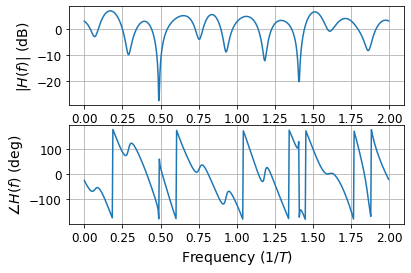

In [6]:
## dispersive channel
hh = np.array([0.1, 0, -0.3j, 0, 0, 1, 0, 0, 0, 0.3j, 0, 0, 0, 0, 0.2-0.7j, 0, 0, 0, 0, 0, 0.1j])

# received signal
rr = np.convolve(sig, hh)

# plot the frequency reponse of the channel
w, H = signal.freqz(hh, whole=True)
ax1=plt.subplot(2,1,1)
ax1.plot(w/np.pi, 20*np.log10(np.abs(H)))
ax1.set_ylabel('$|H(f)|$ (dB)')
ax1.grid()
ax2=plt.subplot(2,1,2)
ax2.plot(w/np.pi, np.angle(H)/np.pi*180)
ax2.set_ylabel(r'$\angle H(f)$ (deg)')
ax2.set_xlabel('Frequency ($1/T$)')
ax2.grid()
plt.show()

The first illustration of the effect of the channel disepersion are the eye diagrams below. Recall that an eye diagram consists of plotting segments of the received signal spanning two symbol periods on top of each other.

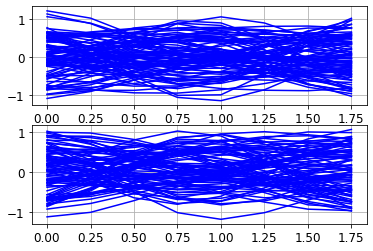

In [7]:
## Eye diagram, plot repeatedly two consecutive symbols
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

start = len(hh) + len(pp)               # trim transient at beginning
end = start + 2*fsT

while end < len(rr) -len(hh) - len(pp): # trim transient at end
    seg = rr[start : end]
    ax1.plot(np.arange(2*fsT)/fsT, seg.real, 'b')
    ax2.plot(np.arange(2*fsT)/fsT, seg.imag, 'b')
    start += 2*fsT
    end += 2*fsT

ax1.grid()
ax2.grid()
plt.show()

The "eyes" are completely closed. There is no sampling instance that allows the symbols to be separated.

For comparison, the plot below shows a perfect eye diagram for QPSK signals. The ideal sampling periods at $t=0.5T$ (or $t=1.5T$) are clearly visible. Note that at those time instances the signal values are all equal to $\pm \frac{\sqrt{2}}{2}$.

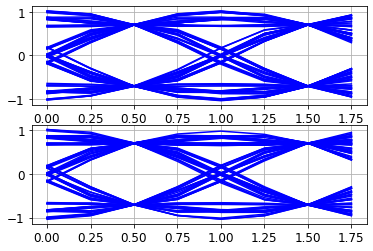

In [8]:
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

rs = np.convolve(sig, pp)
start = len(hh) + len(pp)
end = start + 2*fsT

while end < len(rr) -len(hh) - len(pp):
    seg = rs[start : end]
    ax1.plot(np.arange(2*fsT)/fsT, seg.real, 'b')
    ax2.plot(np.arange(2*fsT)/fsT, seg.imag, 'b')
    start += 2*fsT
    end += 2*fsT

ax1.grid()
ax2.grid()
plt.show()

For the second illustration, we plot a scatter plot of the received signals. Since the oversampling factor is `fsT` is equal to 4, we plot four such scatter plots, one for each sampling phase, in different colors.

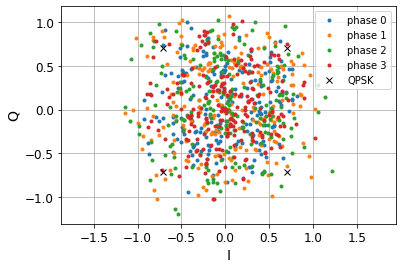

In [9]:
for n in range(fsT):
    plt.plot(rr[n::fsT].real, rr[n::fsT].imag, '.', label="phase {:d}".format(n))
plt.plot(A.real, A.imag, 'kx', label='QPSK')

plt.xlabel('I')
plt.ylabel('Q')
plt.grid()
plt.axis('equal')
plt.legend()
plt.show()

None of the sampling phases, resembles a QPSK constellation.

## Convolution via matrix multiplication

In preparation for devising methods to estimate the channel and to design an equalizer, we need to reformulate the problem. 

The convolution performed by the channel impulse response is difficult to work with. A formulation that expresses the convolution operation as matrix multiplication leads to a much more tractable formulation.

To make matters concrete, we will illustrate the conversion from convolution to matrix multiplication using:

* a short input signal $s[n]$ consisting of $N=8$ symbols with values 1 through 8,
* a short channel with impulse response $c[k] = [1, -2, 3]$,
* the signal is over sampled $M=2$ times. 

The resulting signal $r[k]$ is given by
$$
    r[k] = \sum_{n=0}^7 s[n] \cdot c[k - nM].
$$

This operation is equivalent to first upsampling the input signal, by inserting $M-1$ zeros between samples, and then convolving the upsampled signal with the $c[k]$. 

Throughout, $n$ counts symbol periods and $k$ counts sample periods. 

In [10]:
## generate signal r[k]
ss = np.arange(1, 9)
cc = np.array([1,-2,3])
M = 2

# the output signal has M*(len(ss)-1) + len(cc) non-zero samples
rr = np.zeros(M*(len(ss)-1) + len(cc))
for k in range(len(rr)):
    for n in range(len(ss)):
        if k - M*n >= 0 and k - M*n < len(cc):
            rr[k] += ss[n]*cc[k - M*n]

rr

array([  1.,  -2.,   5.,  -4.,   9.,  -6.,  13.,  -8.,  17., -10.,  21.,
       -12.,  25., -14.,  29., -16.,  24.])

In [11]:
## alternative computation via upsampling and convolution 
up_ss = np.zeros(M * (len(ss) - 1) + 1, dtype=ss.dtype)
up_ss[::M] = ss

np.convolve(up_ss, cc)

array([  1,  -2,   5,  -4,   9,  -6,  13,  -8,  17, -10,  21, -12,  25,
       -14,  29, -16,  24])

Note that the nested loops in the code above are reminiscent of a matrix multiplication. Recall that the multiplication of a $K \times N$ matrix $\mathbf{C}$  with a length $N$ vector $\vec{s}$, yields a length $K$ vector $\vec{r}$. 

The elements of the resulting vector $\vec{r}$ are given by:
$$
    r[k] = \sum_{n=0}^{N-1} A_{k,n} s_n.
$$
This computation is repeated for each of the $K$ elements of $\vec{r}$, which leads to the nested loop for computing the product of $\mathbf{C}$ and $\vec{s}$.

From this analogy, we can define a channel matrix $\mathbf{C}$ such that when it is multiplied by the vector of input symbols yields the output signal.

The computation of matrix $\mathbf{C}$ parallels the convolution operation above.

In [12]:
# the channel matrix CC has dimensions M*(len(ss)-1) + len(cc) by len(ss)
CC = np.zeros((M*(len(ss)-1) + len(cc), len(ss)))
for k in range(len(rr)):
    for n in range(len(ss)):
        if k - M*n >= 0 and k - M*n < len(cc):
            CC[k, n] = cc[k - M*n]

CC

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]])

The matrix $\mathbf{C}$ consists of $N=8$ columns. The $n$-th column begins with $nM$ zeros and is followed by the impulse response $c[k]$. Any remaining positions in the $n$-th column are filled with zeros.

To verify that the product of matrix $\mathbf{C}$ and vector $\vec{s}$ yields the received signal $r[k]$, i.e. is equaivalent to the above convolution, we simply compute that product and compare to the prior result.

In [13]:
# matrix multiplication operator in Python is @ (strange)
r_m = CC @ ss

assert np.allclose(rr, r_m)

r_m

array([  1.,  -2.,   5.,  -4.,   9.,  -6.,  13.,  -8.,  17., -10.,  21.,
       -12.,  25., -14.,  29., -16.,  24.])

We can indeed compute the convolution of the up-sampled input signal and the channel impulse response by a matrix multiplication.

### Another way to use matrix multiplication

Convolution is a symmetric operation. Hence, it should be possible to reverse the roles of inputs signal $s[n]$ and channel impulse response $c[n]$.

We should be able to formulate the upsampled convolution as a product of a matrix formed from the input symbols and a vector that equals the impulse response.

This formulation will be used when we seek to estimate the channel impulse response.

Starting with the original up-sampled convolution, we obtain the alternative formulation by substituting $l=k-nM$. This leads to
$$
    r[k] = \sum_{n=0}^{N-1} s[n] \cdot c[k - nM] = \sum_{l: k-l=nM} c[l] \cdot s[(k-l)/M].
$$
Because of the upsampling of the input signal, the alternative formulation is slightly awkward; the summation includes only terms for which $l$ is such that $k-l$ is a non-negative integer multiple of $M$ (and $l < L$).

Nevertheless, we can compute an input signal matrix $\mathbf{S}$ based on this convolution operation:

In [14]:
# the channel matrix SS has dimensions M*(len(ss)-1) + len(cc) by len(cc)
SS = np.zeros((M*(len(ss)-1) + len(cc), len(cc)))
for k in range(len(rr)):
    for l in range(len(cc)):
        if k - l >= 0 and k - l < M*len(ss) and (k - l) % M == 0:
            SS[k, l] = ss[(k-l)//M]

SS

array([[1., 0., 0.],
       [0., 1., 0.],
       [2., 0., 1.],
       [0., 2., 0.],
       [3., 0., 2.],
       [0., 3., 0.],
       [4., 0., 3.],
       [0., 4., 0.],
       [5., 0., 4.],
       [0., 5., 0.],
       [6., 0., 5.],
       [0., 6., 0.],
       [7., 0., 6.],
       [0., 7., 0.],
       [8., 0., 7.],
       [0., 8., 0.],
       [0., 0., 8.]])

The matrix $\mathbf{S}$ has a simple structure:

* Each column contains the information symbols followed by $M-1$ zeros. Another way to say this: each column contains the upsampled signal.
* In the $n$-th column, the signal is preceded by $n$ zeros.

Thus, the matrix $\mathbf{S}$ is a Toeplitz matrix with the first column given by the up-sampled signal.

Let's again verify that the multiplication of matrix $\mathbf{S}$ and the channel vector $\vec{c}$ yields the received samples:

In [15]:
## multiply S
r_s = SS @ cc
assert np.allclose(rr, r_m)

r_m

array([  1.,  -2.,   5.,  -4.,   9.,  -6.,  13.,  -8.,  17., -10.,  21.,
       -12.,  25., -14.,  29., -16.,  24.])

## Estimating the channel impulse response

We have shown that the vector of received samples can be modeled via the multiplication of a matrix and a vector, plus additive Gaussian noise.

For the purpose of estimating the impulse response $c[k]$, the form with the signal matrix $\mathbf{S}$ is useful. We can write:
$$
    \vec{r} = \mathbf{S} \vec{c} + \vec{N}.
$$

When a training sequence $s_t[n]$ is available, we can construct the signal matrix $\mathbf{S_t}$ from that training signal. 

The goal is then to estimate the channel vector $\vec{c}$ from the vector of received samples $r[l]$ and the training matrix $\mathbf{S_t}$.

The maximum-likelihood estimate of the channel vector is
$$
\vec{\hat{c}} = \arg \min_{\vec{c}} \|\vec{r} - \mathbf{S} \vec{c}\|^2.
$$

The solution to this optimization problem is
$$
    \vec{c} = \mathbf{S}^+ \vec{r}
$$
where $\mathbf{S}^+$ denotes the (Moore-Penrose) pseudo-inverse of $\mathbf{S}$. Since the columns of $\mathbf{S}$ are independent, the pseudo-inverse equals $\mathbf{S}^+ = (\mathbf{S}^H \mathbf{S})^{-1}\mathbf{S}^H$ and, therefore,
$$
    \vec{c} = (\mathbf{S}^H \mathbf{S})^{-1}\mathbf{S}^H \vec{r}
$$

Note: computing the pseudo-inverse is numerically more stable than the explicit inverse. In NumPy, the pseudo-inverse is provided by `np.linalg.pinv`.

Let's verify that we can obtain the channel coefficents $c[k]$ from the samples $r[k]$ and the matrix $\mathbf{S}$.

In [16]:
## show that S+ times rr equals cc
c_hat = np.linalg.pinv(SS) @ rr

assert np.allclose(cc, c_hat)

c_hat

array([ 1., -2.,  3.])

For a more realistic example, we return to the channel used earlier and QPSK symbols. Additionally the received signal samples also contain noise.

We skip the pulse-shaping for this example, so that the impulse response `hh` reflects pulse shaping, channel dispersion, and receiver filtering.

In [17]:
## generate a QPSK signal
fsT = 4
N = 200
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

syms = random_symbols(A, N)

## dispersive channel
cr = np.array([0.1, 0, -0.3j, 0, 0, 1, 0, 0, 0, 0.3j, 0, 0, 0, 0, 0.2-0.7j, 0, 0, 0, 0, 0, 0.1j])
sig = pulse_shape(syms, cr, fsT)

SNR_db = 20
SNR = 10**(SNR_db/10)

# received signal
rrr = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))


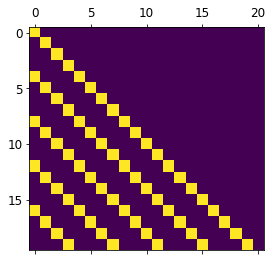

In [18]:
## construct the matrix S via upsampling and use of scipy.linalg.toeplitz
# the first columns of S is the upsampled symbols vector
sc = np.zeros_like(rrr)
sc[0:N*fsT:fsT] = syms

# the first row is [syms[0], 0, ..., 0]
sr = np.zeros_like(hh)
sr[0] = syms[0]

SSr = toeplitz(sc, sr)

# visualize the first few rows of SS - look for band-structure
plt.matshow(np.abs(SSr[:20,:]))

plt.show()

With the $\mathbf{S}$ matrix in hand, we can proceeed to estimate the channel vector $\vec{c}$. 

We will vary the number of received symbols used to estimate $\vec{c}$ and track the accuracy of the estimate. Since the vector `cc` has 21 elements, we will use at least that many samples for channel estimation.

To measure the quality of the estimate, we measure the mean-squared error (MSE) between the received signal $\vec{r}$ and the reconstructed signal $\mathbf{S}\vec{\vec{\hat{c}}}$ over the entire received signal. 

In [19]:
## estimate using different numbers of received samples
K = np.arange(24, len(rrr), 2*fsT, dtype=int)
len_K = len(K)
MSE = np.zeros(len_K)

for n in range(len_K):
    this_K = K[n]            # number of received samples to use
    this_rr = rrr[:this_K]    # trim rr
    this_SS = SSr[:this_K, :] # and SS

    c_hat = np.linalg.pinv(this_SS) @ this_rr

    MSE[n] = np.mean(np.abs(rrr - SSr@c_hat)**2)

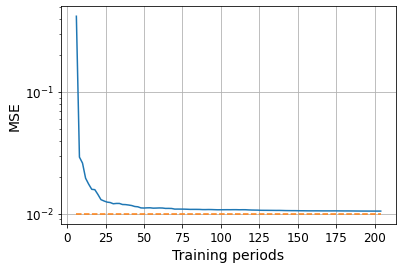

In [20]:
# plot MSE
plt.semilogy(K/fsT, MSE)
plt.semilogy(K/fsT, 1/SNR * np.ones_like(K), '--')

plt.xlabel('Training periods')
plt.ylabel('MSE')
plt.grid()

We can observe that between 25 and 50 training periods are sufficient to estimate the channel. Additional training periods do not improve the quality of the estimate. 

Note, that this observation is specific to the length of the channel. As a rough rule of thumb, you need about 4 or 5 samples per element of the channel impulse response $c[k]$. This implies that the number training periods should be 4-5 times larger than the delay spread $\tau_c$ normalized by the symbol period $T$, $L = \lceil \frac{\tau_c}{T} \rceil$.

## Equalization

An equalizer is a filter with $K$ filter coefficients $w[k]$. The equalizer (usually) works on the $M$ times oversampled signal; this is called a fractionally spaced equalizer.

However, from the perspective of designing the equalizer it is easier to think of the equalizer as taking the inner product between sliding blocks of $K$ consecutive received samples and a vector of equalizer weights $\vec{v}$. The elements of $\vec{v}$ and the impulse response $w[k]$ are related via $w[K-k] = v_k^*$, where $v_k$ is the $k$-th element of $\vec{v}$.

To be specific, to equalize the $m$-th symbol, we construct a length-$K$ vector from the received samples $r[k]$
$$
    \vec{r}_K[m] = [r[k]] \quad \text{for $mM-K_1 < k \leq mM + (K-K_1)$.}
$$
When $K \geq LM$, then $K_1 = K-K_1 = K/2$ is a good choice. 

Note that in each symbol period the window of samples contained in $\vec{r}_K[m]$ advances by $M$ samples.




 

Recall that the received signal samples $r[k]$ can be expressed in terms of the channel matrix $\mathbf{C}$ and the vector of input symbols $\vec{s}$
$$
\vec{r} = \mathbf{C} \vec{s} + \vec{N}.
$$

Selecting consecutive $K$ elements of the received signal $r[k]$ indicates directly which rows of $\mathbf{C}$ are required.

For the example of the length-3 channel, 
for a window size of $K=6$, the vector $\vec{r}_K[2]$ would contain samples $r[4]$ through $r[9]$. The corresponding $K=6$ rows of the matrix
$\mathbf{C}$ are shown below.

In [21]:
# display 6 rows (4 through 9) of the channel matrix
CC[4:10]

array([[ 0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.]])

Note that the first and the trailing three columns of the submatrix containing these $K=6$ rows of $\mathbf{C}$ are all zero. 

Clearly, we don't need those columns. Moreover, the symbols associated with these columns $s[0]$ and $s[5]$ through $s[7]$ do not contribute to the samples $r[4]$ through $r[9]$. Only symbols $s[1]$ through $s[4]$ contribute to those received samples.

Therefore, we can express the vector $\vec{r}_K[2]$ in terms of the $6 \times 4$ submatrix $\mathbf{C}_{[4:10,1:5]}$ and the vector $\vec{s}_4[2]$ consisting  of elements $s[1]$ through $s[4]$:
$$
    \vec{r}_K[2] = \mathbf{C}_{[4:10,1:5]} \cdot \vec{s}_4[2].
$$

Continuing our example,  the next vector $\vec{r}_K[3]$ of received samples contains samples $r[6]$ through $r[11]$ and the corresponding rows of the channel matrix $\mathbf{C}$ are:

In [22]:
CC[6:11]

array([[ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.]])

Notice that this time the first two and the last two columns are all zero. That tells us that the contributing input symbols are $s[2]$ through $s[5]$ and vector $\vec{s}_4[3]$ contains those for symbols.

Moreover, the remaining columns in the center are exactly the same as before, i.e., $\mathbf{C}_{[4:10,1:5]}$ = $\mathbf{C}_{[6:12,2:6]}$.

The number $N$ of information symbols that contribute to $K$ consecutive received samples follows from the convolution operation. When a length $N$ signal is convolved with an impulse response of length $L$, the resulting signal is of length $K=N+L-1$. For $K=6$ and $L=3$, it follows that $N=4$.

In conclusion, we recognize that for $K=6$ the vectors $\vec{r}_k[m]$ are related to a vector of $N=4$ input symbols $\vec{s}_4[m]$ via a *constant* submatrix $\mathbf{C}_{K} = \mathbf{C}_{[2:8,0:4]}$.

In [23]:
CC_K = CC[2:8,0:4]
CC_K

array([[ 3.,  1.,  0.,  0.],
       [ 0., -2.,  0.,  0.],
       [ 0.,  3.,  1.,  0.],
       [ 0.,  0., -2.,  0.],
       [ 0.,  0.,  3.,  1.],
       [ 0.,  0.,  0., -2.]])

The model for the $m$-th received signal block is therefore
$$
    \vec{r}_K[m] = \mathbf{C}_{K} \cdot \vec{s}_N[m] + \vec{N}
$$

Note, minor difficulties arise at the start and end of the received block, where it may be necessary to assume that preceding or subsequent observations, e.g., $r[-1]$, are equal to zero.

### Zero-Forcing Equalizer

An equalizer computes the inner product of the equalizer vector $\vec{v}$ and each block of received samples $\vec{r}_K[m]$. The result is a scalar that should approximate the $m$-th symbol $s[m]$.

The zero-forcing equalizer accomplishes equalization by requring that in each block,
$$
    \vec{v}^H \cdot (\mathbf{C}_k \cdot \vec{s}_N[m]) = s_m,
$$
Note that $s_m$ is an element of $\vec{s}_N[m]$; let's say that $s_m$ is the $d$-th element of $\vec{s}_N[m]$.

Then, the equalizer vector $\vec{v}$ must satisfy
$$
    \vec{v}\mathbf{C}_K = \vec{e}_d^T = [0, \ldots, 0, 1, 0,\ldots 0] \quad \text{where the $1$ is in the $d$-th position.}
$$

Note that the linear syste of equations is under-determined; $K \approx 2N$, i.e., there are more elements of $\vec{v}$ than constraints. The solution is made unique by requiring that $\vec{\hat{v}}$ has the smalles norm of all solutions.

Hence, $\vec{\hat{v}}$ is the solution to the optimization problem:
$$
    \vec{\hat{v}} = \arg \min_{\vec{v}} \|\vec{v}\|^2 \quad \text{subject to: $\vec{v}\mathbf{C}_K = \vec{e}_d^T$} 
$$

The solution to this problem is
$$
    \vec{\hat{v}} = (\mathbf{C}_K^+)^H \cdot \vec{e}_d = \mathbf{C}_K(\mathbf{C}_K^H \mathbf{C}_K) \vec{e}_d 
$$

Let's verify that for our simple signal and channel, the equalization succeeds.

In [24]:
## recreate the symbols and the received signal
ss = np.arange(8)
up_ss = np.zeros(M * (len(ss) - 1) + 1, dtype=ss.dtype)
up_ss[::M] = ss

rr = np.convolve(up_ss, cc)

# equalizer weights
ed = np.array([0,1,0,0])
v = (np.linalg.pinv(CC_K).T).conj() @ ed

# Now, compute the equalizer outputs, we can only get 6 before we run out of samples
rr_hat = np.zeros(6)

for n in range(0, 6):
    rr_hat[n] = v @ rr[2*n:2*n+6]

rr_hat

array([-2.49800181e-16,  1.00000000e+00,  2.00000000e+00,  3.00000000e+00,
        4.00000000e+00,  5.00000000e+00])

### QPSK Example

We return to the earlier example of a QPSK signal transmitted through a dispersive channel. 

For the ZF equalizer, we must 
* first, estimate the channel impulse response,
* then, design the ZF equalizer based on the channel estimate,
* finally, apply the equalizer to the received signal.

#### Channel estimation

Based on our earlier results, we use the first 192 received samples, i.e., 48 symbol periods, to estimate the channel.

In [25]:
# using the received vector `rrr` and signal matrix `SSr` constructed earlier
this_K = 48*4               # number of received samples to use
this_rr = rrr[:this_K]    # trim rr
this_SS = SSr[:this_K, :] # and SS

c_hat = np.linalg.pinv(this_SS) @ this_rr

np.mean(np.abs(rrr - SSr@c_hat)**2)

0.011203293838903254

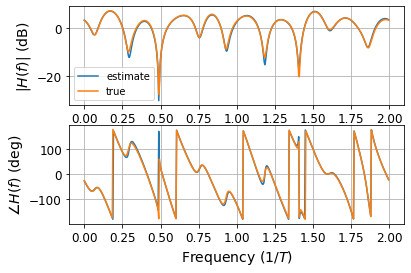

In [26]:
# plot the frequency reponse of the channel
w, H = signal.freqz(c_hat, whole=True)
w, Hr = signal.freqz(cr, whole=True)
ax1=plt.subplot(2,1,1)
ax1.plot(w/np.pi, 20*np.log10(np.abs(H)), label="estimate")
ax1.plot(w/np.pi, 20*np.log10(np.abs(Hr)), label="true")
ax1.set_ylabel('$|H(f)|$ (dB)')
ax1.legend()
ax1.grid()
ax2=plt.subplot(2,1,2)
ax2.plot(w/np.pi, np.angle(H)/np.pi*180)
ax2.plot(w/np.pi, np.angle(Hr)/np.pi*180)
ax2.set_ylabel(r'$\angle H(f)$ (deg)')
ax2.set_xlabel('Frequency ($1/T$)')
ax2.grid()
plt.show()

#### Design Equalizer

The ZF equalizer should be longer than the channel impulse response. Somewhat arbitrarily, we choose $K=2LM-1 = 40$.

We must first construct the channel matrix $\mathbf{C}$ with all non-zero columns removed.


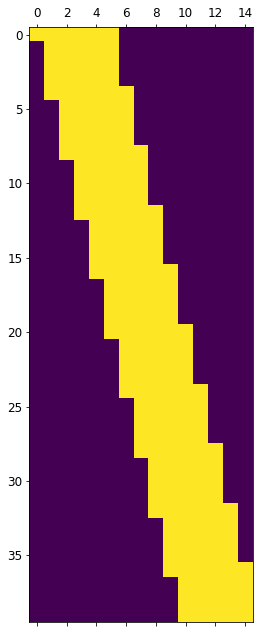

In [42]:
# there is probably a better way to construct the channel matrix, but ...
K = 40
L = len(c_hat)
fsT = 4

# initially we construct the first 2K rows of C; we need N columns
N = (K+L-1) // fsT
C_tmp = np.zeros((2*K, N), dtype=complex)
for n in range(N):
    C_tmp[n*fsT:n*fsT+L, n] = c_hat

# plt.matshow(np.abs(C_hat[:,:])>0)

# then, we select K rows that don't contain empty columns
C_hat = C_tmp[L-1:L-1+K, :]

plt.matshow(np.abs(C_hat[:,:])>0)
plt.show()


With the matrix $\mathbf{C}$ in hand, we can design the equalizer.

In [28]:
# set up the unit vector with a 1 in the d-th position
ed = np.zeros_like(C_hat[0,:])
ed[N//2] = 1

# find the weight vector
vr = (np.linalg.pinv(C_hat).T).conj() @ ed

# and the impulse response of the equalizer
wr = np.flip(vr.conj())

#### Equalized Impulse Response

Intuitively, he convolution of channel impulse response and equalizer should yield a frequency response that is approximately flat.

However, that is not true in general as the frequency response below shows..

Recall that the  condition for "no-ISI" requires only that the effective pulses are Nyquist pulses.

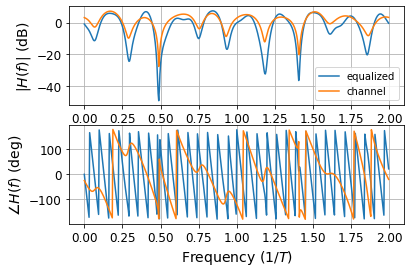

In [29]:
# plot the frequency reponse of the equalized channel
w, H = signal.freqz(np.convolve(cr, wr), whole=True)
w, H1 = signal.freqz(cr, whole=True)
ax1=plt.subplot(2,1,1)
ax1.plot(w/np.pi, 20*np.log10(np.abs(H)), label="equalized")
ax1.plot(w/np.pi, 20*np.log10(np.abs(H1)), label="channel")
ax1.set_ylabel('$|H(f)|$ (dB)')
ax1.legend()
ax1.grid()
ax2=plt.subplot(2,1,2)
ax2.plot(w/np.pi, np.angle(H)/np.pi*180)
ax2.plot(w/np.pi, np.angle(H1)/np.pi*180)
ax2.set_ylabel(r'$\angle H(f)$ (deg)')
ax2.set_xlabel('Frequency ($1/T$)')
ax2.grid()
plt.show()

#### Eye Diagram

To assess the quality of the equalization, it is more useful to consider the eye diagram of the received signal.

The eye diagram below shows clearly that the ISI introduced by the channel has been successfully mitigated.

This is further confirmed by the constellation diagram.

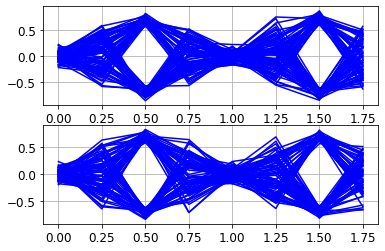

In [30]:
## equalize the signal
rr_eq = np.convolve(rrr, wr)

## Eye diagram, plot repeatedly two consecutive symbols
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

start = len(cr) + len(wr)               # trim transient at beginning
end = start + 2*fsT

while end < len(rr_eq) - len(cr) - len(wr): # trim transient at end
    seg = rr_eq[start : end]
    ax1.plot(np.arange(2*fsT)/fsT, seg.real, 'b')
    ax2.plot(np.arange(2*fsT)/fsT, seg.imag, 'b')
    start += 2*fsT
    end += 2*fsT

ax1.grid()
ax2.grid()
plt.show()

Text(0, 0.5, 'Q')

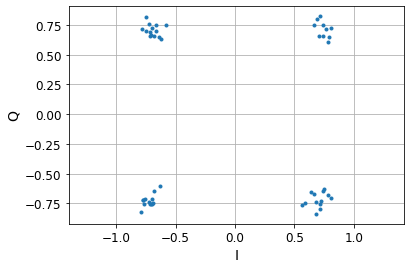

In [31]:
## constellation plot
# exclude transients
ns = len(cr) + len(wr) + 2
ne = ns + len(syms)

plt.plot(rr_eq[ns:ne:fsT].real, rr_eq[ns:ne:fsT].imag, '.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

### MMSE Equalizer

The MMSE equalizer estimates the equalizer weights directly without first estimating the impulse response of the channel.

The point of departure for the MMSE equalizer is that the down-sampled equalizer output
$$
    y[m] =  \vec{v}^H \cdot \vec{r}[mM] =
      \langle \vec{r}[mM], \vec{v} \rangle
$$
should closely resemble the $m$-th information symbol.

As before $\vec{v}$ is the vector of equalizer weights.

As before $\vec{r}$ represents a vector of $K$ consecutive received samples. Specifically, the vector $\vec{r}[mM]$ contains the received samples $r[mM]$ through $r[mM+K]$.

The MMSE equalizer minimizes the mean-squared error between symbols $s_m$ and equalizer outputs $y[m]$. The optimal weight vector $\hat{\vec{v}}$ is the minimizer of
$$
    J_n(\vec{v}) = \sum_{m=0}^{n} |e[m]|^2 = \sum_m |s_m - \vec{v}^H \cdot \vec{r}[mM]|^2.
$$

We have shown that the optimal weight vector is given by
$$
    \hat{\vec{v}}_n = \arg \min_{\vec{v}} J_n(\vec{v}) =
      \mathbf{R}_n^{-1} \vec{p}_n,
$$
with 
$$
  \mathbf{R}_n = \frac{1}{n+1} \sum_{m=0}^{n}\vec{r}[mM]\vec{r}^H[mM] 
      \quad \text{ and } \quad
      \vec{p}_n = \frac{1}{n+1} \sum_{m=0}^{n-1}\vec{r}[mM] s_m^*
$$

### QPSK Example

We illustrate the MMSE equalizer using the QPSK signal from above. 

The computation proceeds by:
* first computing the autocorrelation matrix $\mathbf{R}$
* and the cross-correlation vector $\vec{p}$.
* Finally, the weight vector $\vec{v}$ is computed.

The equalizer length is again $K=40$. 

The first 96 symbol periods are used to determine the equalizer weights. This many observations are needed to achieve good equalization for this example. The problem is that $K=40$ coefficients are estimated; this is a real down-side of using a four times oversampled equalizer. Also, the channel is fairly long (as it covers five symbol periods)

In [32]:
K = 40
N = 96

## compute matrix R and vector p_vec
RR = np.zeros((K, K), dtype=complex)
pp = np.zeros((K, 1), dtype=complex)

for m in range(N):
    # we construct r_vec carefully so that it is a column vector 
    # to line up with the math above
    r_vec = np.array([rrr[m*fsT: m*fsT+K]]).T

    RR += r_vec @ r_vec.conj().T  # second vector is Hermitian of first
    pp += r_vec * np.conj(syms[m])

vr = np.linalg.solve(RR, pp) 
wr = np.flip(np.squeeze(vr).conj())# squeeze removes the "singleton" dimension from v
    

#### Eye Diagram

As before, we consider the eye diagram of the received signal to assess the quality of the equalization.

The eye diagram below shows clearly that the ISI introduced by the channel has been successfully mitigated.


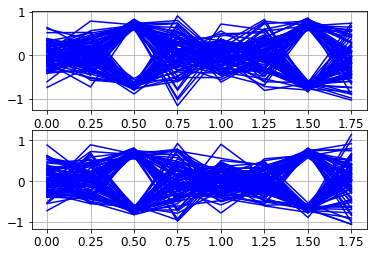

In [33]:
## equalize the signal
rr_eq = np.convolve(rrr, wr)

## Eye diagram, plot repeatedly two consecutive symbols
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

start = len(cr) + len(wr)               # trim transient at beginning
end = start + 2*fsT

while end < len(rr_eq) - len(cr) - len(wr): # trim transient at end
    seg = rr_eq[start : end]
    ax1.plot(np.arange(2*fsT)/fsT, seg.real, 'b')
    ax2.plot(np.arange(2*fsT)/fsT, seg.imag, 'b')
    start += 2*fsT
    end += 2*fsT

ax1.grid()
ax2.grid()
plt.show()

## Adaptive Equalization

Often, the impulse response of the channel is time-varying. Then, the weights of the equalizer must be adapted continuously (by using symbol decisions in place of training symbols).

Or, only a few training symbols are available. Then adaptation of the equalizer must proceed rapidly.

The two best known adaptive algorithms are
* recursive least squares (RLS)
* least mean squares (LMS)

Both algorithms, update equalizer weights by seeking the minimum of the objective function
$$
    J_n(\vec{v}) = \sum_{m=0}^{n} \lambda^{n-m} |e[m]|^2 =
      \sum_{m=0}^n \lambda^{n-m} |s_m - \vec{v}^H \cdot \vec{r}[mM]|^2,
$$
where index $n$ indicates that $n$ symbols have been observed.

The metric $J_n(\vec{v})$ can be computed recursively in $n$:
$$
   J_n(\vec{v}) = \lambda J_{n-1}(\vec{v}) + |s_n - \vec{v}^H \cdot \vec{r}[nM]|^2.
$$

### RLS

To derive the RLS algorithm, we begin with the gradient of $J_n(\vec{v})$:
$$
    \nabla_{\vec{v}^H} J_n(\vec{v}) = \lambda \nabla_{\vec{v}^H} J_{n-1}(\vec{v}) + 
    \vec{r}[nM]\vec{r}^H[nM] \cdot \vec{v} - \vec{r}[nM] s_n^*.
$$

We know that the optimal solution after $n-1$ symbols satifies
$$
    \nabla_{\vec{v}^H} J_{n-1}(\vec{v}) = \mathbf{R}_{n-1} \vec{v}_{n-1} - \vec{p}_{n-1} = \vec{0}.
$$

Therefore, the optimal solution after $n$ symbols must satisfy:
$$
    \nabla_{\vec{v}^H} J_n(\vec{v}) = (\lambda \mathbf{R}_{n-1} + \vec{r}[nM]\vec{r}^H[nM]) \vec{v}_n -
    (\lambda \vec{p}_{n-1} + \vec{r}[nM] s_n^*) = \vec{0}.
$$

Using the matrix inversion lemma, the solution $\vec{v}_n$ can be expressed recursively without a matrix inverse as
$$
 \vec{v}_n = \vec{v}_{n-1} +
      \frac{e^*[n] \mathbf{R}_{n-1}^{-1} \vec{r}[nM]}
      {\lambda + \vec{r}^H[nM]\mathbf{R}_{n-1}^{-1} \vec{r}[nM]}.
$$

The class below implements the RLS algorithm.

In [34]:
class RLS():
    """class for carrying out the RLS algorithm"""

    def __init__(self, K, lam=1):
        self.K = K       # length of equalizer
        self.lam = lam   # forgetting factor

        self.R_inv = 1*np.eye(K, dtype=complex)
        self.v = np.zeros(K, dtype=complex)

    def update(self, vec_r, sym):
        """RLS recursion, returns updated weight vector"""
        # error
        e = sym - self.equalize(vec_r)

        # compute R_inv * vec_r
        vec_g = self.R_inv @ np.expand_dims(vec_r, 1)

        # update R_inv
        denom = (self.lam + vec_r.conj() @ vec_g)
        self.R_inv = 1/self.lam * (self.R_inv - 
                    vec_g @ vec_g.conj().T / denom)

        # update weight vector
        self.v += np.squeeze(vec_g) * e.conj()/denom

        return self.v

    def equalize(self, vec_r):
        """compute equalizer output"""
        
        return self.v.conj() @ vec_r

#### Example

We use a QPSK signal to evaluate the RLS adaptation. 

A total of $N=500$ QPSK symbols are generated. Of these, the first $N_t$ are used to traun the equalizer and the remaining $N-N_t$ are used to measure the mean-squared error (MSE).

The goal is to assess how quickly the RLS algorithm reaches a set of equalizer weights with small MSE.

In [35]:
## generate a QPSK signal
fsT = 2
N = 500
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

syms = random_symbols(A, N)

## dispersive channel
ca = np.array([0.1,  -0.3j, 0, 1,  0, 0.3j, 0, 0, 0.2-0.7j, 0, 0, 0.1j])
sig = pulse_shape(syms, cr, fsT)

SNR_db = 20
SNR = 10**(SNR_db/10)

# received signal
rra = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))


In [36]:
## measure MSE for different trining lengths Nt
K = 24
lam = 0.99

Nt = np.arange(0, 200, 4)
MSE = np.zeros_like(Nt, dtype=float)

for n in range(len(Nt)):
    this_Nt = Nt[n]

    # instantiate RLS
    rls = RLS(K, lam)
    
    Nm = 0
    m = 0
    while m*fsT + K < len(rra):
        vec_r = rra[m*fsT : m*fsT+K]

        if m <= this_Nt:
            # training
            rls.update(vec_r, syms[m])
        else:
            # equalize
            MSE[n] += np.abs(syms[m] - rls.equalize(vec_r))**2
            Nm += 1

        m += 1

    MSE[n] = MSE[n]/Nm

    


The RLS algorithm reaches very low MSE with as few as 25 training symbols (for a length $K=24$ equalizer).

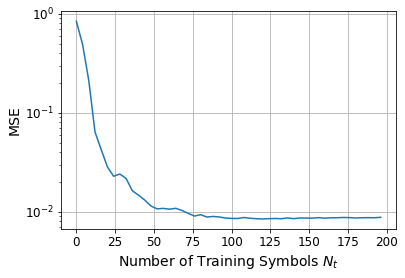

In [37]:
plt.semilogy(Nt, MSE)
plt.grid()

plt.xlabel('Number of Training Symbols $N_t$')
plt.ylabel('MSE')

plt.show()

### LMS

The LMS algorithm is simpler than the RLS algorithm.

In each iteration, the update takes a small step in the direction of steepest descent (i.e., the negative gradient).

If we assume that the weight vector is optimal in period
$n-1$, i.e., $\vec{v}_{n-1} = \mathbf{R}_{n-1}^{-1} \vec{p}_{n-1}$,
then
$$
\nabla_{\vec{v}^H} J_n(\mathbf{R}_{n-1}^{-1} \vec{p}_{n-1}) =
      \vec{r}[nM]\vec{r}^H[nM] \cdot \vec{v}_{n-1} - \vec{r}[nM] s_n^* =
     - \vec{r}[nM] \cdot e^*[n]
$$

Therefore, the updated weight vector is given by
$$
    \vec{v}_n = \vec{v}_{n-1} + \mu \vec{r}[nM] \cdot e^*[n].
$$

The normalized LMS algorithm makes the update invariant to the amplitude of the received signal by choosing a step size $\mu$ that is scaled by the power of the received signal, e.g., 
$$
    \vec{v}_n = \vec{v}_{n-1} + \frac{\mu}{\vec{r}^H[nM]\vec{r}[nM] + \alpha} \vec{r}[nM] \cdot e^*[n].
$$

Below is a class that implements the LMS algorithm.

In [38]:
class LMS():
    """class for carrying out the LMS algorithm"""

    def __init__(self, K, mu=0.5):
        self.K = K       # length of equalizer
        self.mu = mu   # forgetting factor

        self.v = np.zeros(K, dtype=complex)
        self.alpha = 0.1      # small positive constant

    def update(self, vec_r, sym):
        """RLS recursion, returns updated weight vector"""
        # error
        e = sym - self.equalize(vec_r)

        # update weight vector
        scale = self.mu / (self.alpha + vec_r.conj() @ vec_r)
        self.v += vec_r * e.conj() * scale

        return self.v

    def equalize(self, vec_r):
        """compute equalizer output"""
        
        return self.v.conj() @ vec_r

As with the RLS algorithm, we evaluate the MSE as a function of the length of the training period.

In [39]:
## measure MSE for different trining lengths Nt
K = 24
mu = 0.5

Nt = np.arange(0, 200, 4)
MSE_L = np.zeros_like(Nt, dtype=float)

for n in range(len(Nt)):
    this_Nt = Nt[n]

    # instantiate RLS
    lms = LMS(K, mu)
    
    Nm = 0
    m = 0
    while m*fsT + K < len(rra):
        vec_r = rra[m*fsT : m*fsT+K]

        if m <= this_Nt:
            # training
            lms.update(vec_r, syms[m])
        else:
            # equalize
            MSE_L[n] += np.abs(syms[m] - lms.equalize(vec_r))**2
            Nm += 1

        m += 1

    MSE_L[n] = MSE_L[n]/Nm


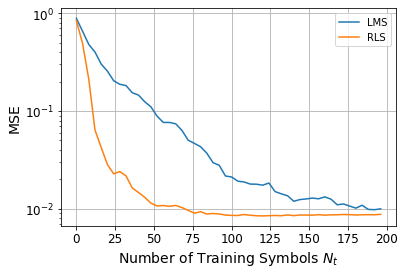

In [40]:
plt.semilogy(Nt, MSE_L, label="LMS")
plt.semilogy(Nt, MSE, label="RLS")
plt.grid()

plt.xlabel('Number of Training Symbols $N_t$')
plt.ylabel('MSE')
plt.legend()

plt.show()

Clearly, with the RLS algorithm the equalizer converges much more rapidly.